In [17]:
import csv
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.optimize import root, fsolve
from scipy.special import binom
import pandas as pd
import time

In [40]:
# Initial data
p_a = 1
Nr = N = 3
nodes = 50
T_max = 12

T_idle = 3
T_bo = 3
T_rts = 3
T_cts = 3
T_data = 3
T_ack = 3

T_out = T_data + T_ack
T_wait = T_data + T_ack


In [41]:
def csma_E_tc(p, p_f):
    if p_f == 1.:
        p_f = 0.9999999
    elif p_f == 0.:
        p_f = 0.0000001
    total_sum = 0
    for i in range(1, Nr + 1 + 1):
        first_addition = T_wait + T_bo / (1 - p_f)
        numerator = (2**i * T_max + 1) * (p_f ** (2**i * T_max + 1) - 2**i * T_max * p_f - p_f + 2**i * T_max)
        denominator = 2**i * T_max * (1 - p_f ** (2**i * T_max + 1))
        second_addition = (1 - p) * (T_cts + T_data + T_ack)
        huge_sum = T_rts + p * T_out / p_f + first_addition * numerator / denominator + second_addition
        total_sum += p ** (i - 1) * huge_sum
    return T_idle + p_a * total_sum

def csma_pi_idle(p, p_f):
    return T_idle / csma_E_tc(p, p_f)

def csma_pi_rts(p, p_f):
    total_sum = 0
    for i in range(1, Nr + 1 + 1): 
        numerator = p ** (i - 1) * p_a * T_rts
        denominator = csma_E_tc(p, p_f)
        total_sum += numerator / denominator
    return total_sum

def csma_pi_out(p, p_f):
    total_sum = 0
    for i in range(1, Nr + 1 + 1): 
        numerator = p ** (i - 1) * p_a * p * T_out / p_f
        denominator = csma_E_tc(p, p_f)
        total_sum += numerator / denominator
    return total_sum

def csma_pi_cts(p, p_f):
    total_sum = 0
    for i in range(1, Nr + 1 + 1): 
        numerator = (1 - p) * p ** (i - 1) * p_a * T_cts
        denominator = csma_E_tc(p, p_f)
        total_sum += numerator / denominator
    return total_sum

def csma_pi_bo(p, p_f):
    if p_f == 1.:
        p_f = 0.9999999
    total_sum = 0
    for i in range(1, Nr + 1 + 1): 
        numerator = p ** (i - 1) * p_a * T_bo * (2**i * T_max + 1) * (p_f ** (2**i * T_max + 1) - 2**i * T_max * p_f - p_f + 2**i * T_max)
        denominator = csma_E_tc(p, p_f) * (2**i * T_max) * (1 - p_f) * (1 - p_f ** (2**i * T_max + 1))
        total_sum += numerator / denominator
    return total_sum

def csma_pi_bo_1_sara(p, p_f):
    if p_f == 1.:
        p_f = 0.9999999
    total_sum = 0
    for i in range(1, Nr + 1 + 1): 
        numerator = p ** (i - 1) * p_a * T_bo * (2**i * T_max + 1) * (1 - p_f ** (2**i * T_max))
        denominator = csma_E_tc(p, p_f) * (2**i * T_max) * (1 - p_f ** (2**i * T_max + 1))
        total_sum += numerator / denominator
    return total_sum

def csma_pi_wait(p, p_f):
    if p_f == 1.:
        p_f = 0.9999999
    total_sum = 0
    for i in range(1, Nr + 1 + 1): 
        numerator = p ** (i - 1) * p_a * T_wait * (2**i * T_max + 1) * (p_f ** (2**i * T_max + 1) - 2**i * T_max * p_f - p_f + 2**i * T_max)
        denominator = csma_E_tc(p, p_f) * (2**i * T_max) * (1 - p_f ** (2**i * T_max + 1))
        total_sum += numerator / denominator
    return total_sum

def csma_pi_data(p, p_f):
    total_sum = 0
    for i in range(1, Nr + 1 + 1): 
        numerator = (1 - p) * p ** (i - 1) * p_a * T_data
        denominator = csma_E_tc(p, p_f)
        total_sum += numerator / denominator
    return total_sum

def csma_pi_ack(p, p_f):
    total_sum = 0
    for i in range(1, Nr + 1 + 1): 
        numerator = (1 - p) * p ** (i - 1) * p_a * T_ack
        denominator = csma_E_tc(p, p_f)
        total_sum += numerator / denominator
    return total_sum

In [42]:
def csma_p_success(p):
    total_sum = 0
    for i in range(1, Nr + 1 + 1):
        total_sum += (1 - p) * p ** (i - 1) * p_a
    return total_sum

# alternative formula
def csma_p_success(p):
    return 1 - p ** (Nr + 1)

def csma_p_failure(p):
    return p ** (Nr + 1)

In [43]:
# def csma_saturation(p, p_f, node):
#     p_rts = csma_pi_rts(p, p_f)
#     p_cts = csma_pi_cts(p, p_f)
#     p_data = csma_pi_data(p, p_f)
#     p_ack = csma_pi_ack(p, p_f)
    
#     P_tr = 1 - ((1 - p_rts - p_cts - p_data - p_ack) ** (nodes))
    
#     pr_success = csma_p_success(p)
#     Ew = T_rts * (1 / P_tr - 1)
#     pr_failure = csma_p_failure(p)
#     tp = 0.
#     T_success = T_rts + T_cts + T_data + T_ack + 4 * tp
#     T_failure = T_rts + tp
#     numerator = T_success * pr_success
#     denominator = Ew + T_success * pr_success + T_failure * pr_failure
#     S = numerator / denominator
#     return S

In [44]:
def transcendental_equation_p_collision(p, p_f, n):
    p_rts = csma_pi_rts(p, p_f)
    p_cts = csma_pi_cts(p, p_f)
#     p_data = csma_pi_data(p, p_f)
#     p_ack = csma_pi_ack(p, p_f)
#     p_bo_1 = csma_pi_bo_1_sara(p, p_f)
    
    p1 = (1 - p_cts) ** (n-1) - (1 - p_rts - p_cts) ** (n-1)
    p2 = (n - 1) * p_cts * (1 - p_cts) ** (n-2)
    return p - (p1 + p2)


def transcendental_equation_p_free(p, p_f, n):
#     p_rts = csma_pi_rts(p, p_f)
    p_cts = csma_pi_cts(p, p_f)
#     p_data = csma_pi_data(p, p_f)
#     p_ack = csma_pi_ack(p, p_f)
    return p_f - ((1 - p_cts) ** (n-1))

def system_of_equations(p_pf, node):
    p, pf = p_pf
    return (transcendental_equation_p_collision(p, pf, node), transcendental_equation_p_free(p, pf, node))

def csma_calculate_transcendental_equation():
    p_array = []
    pf_array = []
    for node in range(1, nodes+1):
        p, pf = fsolve(system_of_equations, (0.01, 0.01), args=(node))
        p_array.append(p)
        pf_array.append(pf)
    return np.array(p_array), np.array(pf_array)

In [45]:
p_collision_csma_an, p_free_csma_an = csma_calculate_transcendental_equation()
p_success_csma_an = csma_p_success(p_collision_csma_an)
p_failure_csma_an = csma_p_failure(p_collision_csma_an)
cycle_time_csma_an = [csma_E_tc(lp, lpf) for lp, lpf in zip(p_collision_csma_an, p_free_csma_an)]

In [46]:
analytics_headers = [
    'nodes',
    'p_collision',
    'p_failure',
    'p_success',
    'p_free',
    'p_busy',
    'cycle_time',
]

data = [analytics_headers]
for i in range(nodes):
    data.append([
        i + 1,
        p_collision_csma_an[i],
        csma_p_failure(p_collision_csma_an[i]),
        csma_p_success(p_collision_csma_an[i]),
        p_free_csma_an[i],
        1 - p_free_csma_an[i],
        csma_E_tc(p_collision_csma_an[i], p_free_csma_an[i]),
    ])
    

# Here we save our table to csv in the same folder
with open(f"{time.strftime('AN %Y-%m-%d T %H-%M-%S')}.csv", "wt", newline="") as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow(analytics_headers)
    for i in range(1, len(data)):
        writer.writerow(data[i])

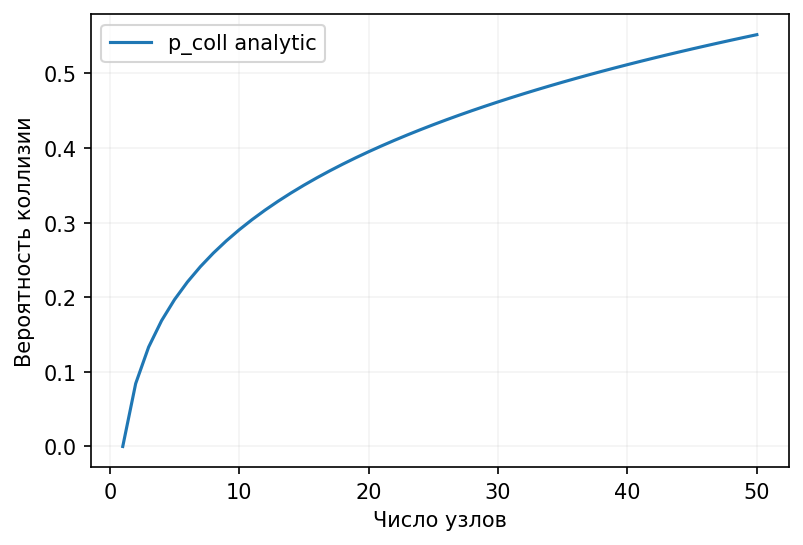

In [47]:
plt.figure(dpi=150)
plt.plot(np.arange(1, nodes + 1), p_collision_csma_an, label="p_coll analytic")
# plt.plot(np.arange(1, nodes + 1), p_free_csma_an, label="p_free analytic")
plt.xlabel("Число узлов")
plt.ylabel("Вероятность коллизии")
plt.legend()
plt.grid(alpha=0.15)
# plt.savefig("plots/aloha_collision.png", dpi=600)
plt.show()